1. Import Libraries

In [92]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

2. Import phi and phi_test from train and test datasets using NumPy's loadtxt function

In [93]:
phi = np.loadtxt('train.csv', skiprows=1, delimiter=',', dtype='float', usecols=tuple(range(1, 14)))
phi_test = np.loadtxt('test.csv', skiprows=1, delimiter=',', dtype='float', usecols=tuple(range(1, 14)))
phi[0], phi_test[0]

(array([  0.95577,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.047  ,
         88.8    ,   4.4534 ,   4.     , 307.     ,  21.     , 306.38   ,
         17.28   ]),
 array([1.0612e-01, 3.0000e+01, 4.9300e+00, 0.0000e+00, 4.2800e-01,
        6.0950e+00, 6.5100e+01, 6.3361e+00, 6.0000e+00, 3.0000e+02,
        1.6600e+01, 3.9462e+02, 1.2400e+01]))

3. Import y from train dataset using the loadtxt function

In [94]:
y = np.loadtxt('train.csv', skiprows=1, dtype='float', usecols=14, ndmin=2, delimiter=',')
y[0]

array([14.8])

4. Concatenate coloumn of 1s to right of phi and phi_test

In [95]:
phi = np.concatenate((phi, np.ones((400, 1))), axis=1)
phi_test = np.concatenate((phi_test, np.ones((105, 1))), axis=1)
phi[0], phi_test[0]

(array([  0.95577,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.047  ,
         88.8    ,   4.4534 ,   4.     , 307.     ,  21.     , 306.38   ,
         17.28   ,   1.     ]),
 array([1.0612e-01, 3.0000e+01, 4.9300e+00, 0.0000e+00, 4.2800e-01,
        6.0950e+00, 6.5100e+01, 6.3361e+00, 6.0000e+00, 3.0000e+02,
        1.6600e+01, 3.9462e+02, 1.2400e+01, 1.0000e+00]))

5. Apply min max scaling on each coloumn of phi and phi_test
> ![](2022-10-27-18-02-57.png)

In [96]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(phi)
phi = scaler.transform(phi)
phi_test = scaler.transform(phi_test)

6. Apply log scaling on y

In [97]:
y = np.log(y)

7. Define a function to calculate change in error function based on phi, w and p norm
> ![](2022-10-27-18-07-08.png)

In [98]:
def CostFunction(p, beta, phi, lamb):
    
    # L2 Cost function gradient
    if p == 2:
        dJ = (2 * (np.dot(np.dot(np.transpose(phi), phi), beta) - np.dot(np.transpose(phi), y)) + 
            lamb*p*np.power(np.absolute(beta), (p-1)))
        
    # Lp Cost function gradient
    elif p >= 1 and p < 2:
        dJ = (2 * (np.dot(np.dot(np.transpose(phi), phi), beta) - np.dot(np.transpose(phi), y)) + 
            lamb*p*np.power(np.absolute(beta), (p-1))*np.sign(beta))
    return dJ

8. Make a dictionary containing filenames as keys and p as values

In [99]:
# I would like to append predicted MEDV values in output.csv for different p values
p_values = [2.0, 1.75, 1.5, 1.3, 1.0]

9. For each p value predict MEDV

In [100]:
for p in p_values:
    
    # Set the `w` or `β` to all 0s
    beta = np.zeros((14, 1))
    
    # Set an appropriate value for `lambda` and `step size`
    lamb = 0.2
    t = 0.0001
    
    # Calculate new value of `w` or `β`
    beta_new = beta - t * CostFunction(p, beta, phi, lamb)
    
    # Repeat steps until error between consecutive `w`s or `β`s is less than threshold
    i = 0
    while (np.linalg.norm(beta_new-beta) > 0.00001):
        
        # Gradient Descent Method
        beta = beta_new
        beta_new = beta - t * CostFunction(p, beta, phi, lamb)
        
        i += 1 # iteration count
    
    print('Lp norm: ', p, ', Total Iterations: ', i)
    
    # Load values of `id` from test data file
    df = pd.read_csv('output.csv')
    del df['Unnamed: 0']
    
    # Calculate `y` for test data using `phi_test` and applying inverse log
    y_predict = np.dot(phi_test, beta_new)
    y_predict = np.exp(y_predict)
    
    # Save the `id`s and `y` according to filename from dictionary
    name = f'L{p}_MEDV'
    df[name] = y_predict
    df.to_csv('output.csv')

Lp norm:  2.0 , Total Iterations:  7862
Lp norm:  1.75 , Total Iterations:  6796
Lp norm:  1.5 , Total Iterations:  6800
Lp norm:  1.3 , Total Iterations:  6792
Lp norm:  1.0 , Total Iterations:  6789


Conclusion

In [101]:
df.head() # All perdicted MEDV

,ID,LR_MEDV,L2.0_MEDV,L1.75_MEDV,L1.5_MEDV,L1.3_MEDV,L1.0_MEDV
0,0,21.715287,21.293240,21.211613,21.196973,21.187179,21.169197
1,1,26.462126,22.892581,22.924649,22.943314,22.959495,22.988855
2,2,16.766338,5.268038,5.269272,5.280456,5.286219,5.290187
3,3,17.454942,29.012182,28.990695,29.043694,29.079674,29.116893
4,4,23.734498,10.950729,10.972862,10.994232,11.012415,11.043737


In [102]:
df[['LR_MEDV', 'L2.0_MEDV', 'L1.75_MEDV', 'L1.5_MEDV', 'L1.3_MEDV', 'L1.0_MEDV']].corr()

,LR_MEDV,L2.0_MEDV,L1.75_MEDV,L1.5_MEDV,L1.3_MEDV,L1.0_MEDV
LR_MEDV,1.000000,0.734547,0.738624,0.739893,0.740635,0.741358
L2.0_MEDV,0.734547,1.000000,0.999885,0.999795,0.999710,0.999557
L1.75_MEDV,0.738624,0.999885,1.000000,0.999983,0.999950,0.999873
L1.5_MEDV,0.739893,0.999795,0.999983,1.000000,0.999991,0.999945
L1.3_MEDV,0.740635,0.999710,0.999950,0.999991,1.000000,0.999980
L1.0_MEDV,0.741358,0.999557,0.999873,0.999945,0.999980,1.000000


<AxesSubplot:>

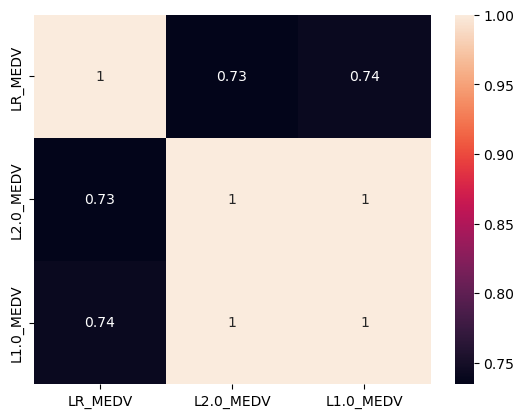

In [103]:
# Correlation between Linear, Ridge, LASSO Regression
sns.heatmap(df[['LR_MEDV', 'L2.0_MEDV', 'L1.0_MEDV']].corr(), annot=True)

<AxesSubplot:>

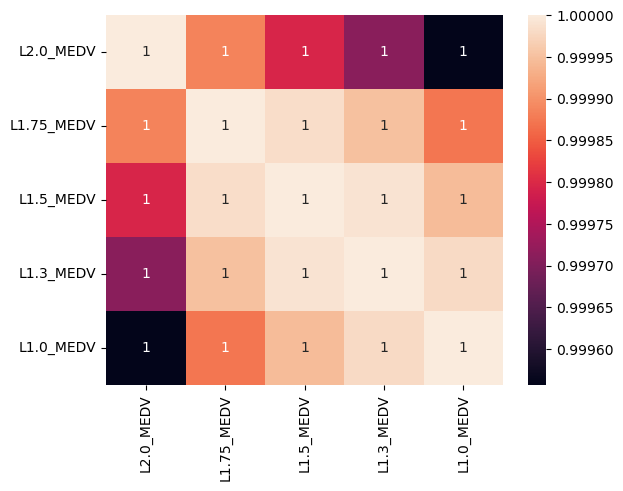

In [104]:
# Correlation between L2 (RIDGE), L1 (LASSO), L1.75, L1.5, 1.3 Regression
sns.heatmap(df[['L2.0_MEDV', 'L1.75_MEDV', 'L1.5_MEDV', 'L1.3_MEDV', 'L1.0_MEDV']].corr(), annot=True)